In [1]:
# импорт необходимых библиотек
import os
import re
import time
import pandas as pd
import numpy as np
from typing import List
from docx import Document
from transformers import BartTokenizer, BartForConditionalGeneration
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

/home/ruslan/atom/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def walk_path_files(directory: str) -> List[List[str]]:
    """функция получение patch файлов по контексту

    Args:
        directoty (str): путь к директории с файлами

    Returns:
        List[List[str]]: списки файлов HMI и SSTS
    """
    # списки файлов HMI и SSTS
    hmi_files = []
    ssts_files = []

    # получение patch файлов по контексту
    for root, dirs, files in os.walk(directory, topdown = False):
        for name in files:
            # файлы директории HMI
            if "HMI" in root:
                hmi_files.append(os.path.join(root, name))
            # файлы директории SSTS
            if "SSTS" in root:
                ssts_files.append(os.path.join(root, name))

    return [hmi_files, ssts_files]

In [3]:
def open_docx_file(pacth: str, file_folder: str)-> List[str]:
    """функция извлечения текста из файлов с расширением .docx

    Args:
        pacth (str): путь к файлу

    Returns:
        List[str]: [наименование функции, текс файла]
    """

    document = Document(pacth)
    paragraphs = [p.text.strip().replace("\xa0", " ") for p in document.paragraphs if len(p.text) != 0]

    if file_folder == "HMI":
        return [paragraphs[0].split("]")[-1].strip(), " ".join(paragraphs[1:])]
    if file_folder == "SSTS":
        return [paragraphs[0].strip(), " ".join(paragraphs[1:])]

In [4]:
def findall_numbers(text: str) -> int:
    """функция извлечения номера файла из patch файла

    Args:
        text (str): путь к файлу

    Returns:
        int: номер файла
    """
    numbers = re.findall(r'\b\d+\b', text)
    return numbers[0]

In [5]:
def file_processing(list_files: List[str], directory_name: str = "HMI") -> List[List[str]]:
    """функция извлечени ключевых призноков из файла

    Args:
        phmi_files: List[str]: список путей к файлам
        directory_name: наименование директории с файлами

    Returns:
        List[Lst[str]]: признаки данных
    """

    # обработка файлов 
    text_list = []
    for file in list_files:
        name, text = open_docx_file(file, directory_name)
        number = findall_numbers(file)
        # формирование признаков
        text_list.append([number, name, text])

    return  text_list

In [6]:
def make_df(text: List[str]) -> pd.DataFrame:
    """функция преобразования текста в Data Frame

    Args:
        text (List[str]): признаки данных файлов

    Returns:
        pd.DataFrame: Data Frame с данными призноков по каждому файлу
    """

    df = pd.DataFrame(text, columns=["Number", "Name", "Text"])

    return df

In [7]:
def merge_df(hmi_df: pd.DataFrame, ssts_df: pd.DataFrame) -> pd.DataFrame:
    """функция объединения признаков данных

    Args:
        hmi_df (pd.DataFrame): Data Frame с данными призноков файлов HMI
        ssts_df (pd.DataFrame): Data Frame с данными призноков файлов SSTS

    Returns:
        pd.DataFrame: признаки данных по документации
    """

    df = hmi_df.merge(ssts_df, on="Number", how="left", suffixes=["_uc", "_ssts"])
    df = df.fillna("-")

    return df

In [8]:
# Загрузка модели и токенизатора BART
model = BartForConditionalGeneration.from_pretrained("./bart_model")
tokenizer = BartTokenizer.from_pretrained("./bart_model")

In [9]:
# загрузка берт с локального компа
model_bert = SentenceTransformer('./roberta_model')

In [10]:
def generate_difference(row):
    text1 = row['Text_uc']
    text2 = row['Text_ssts']

    # Форматирование входных данных для модели BART
    input_text = (
        f"Identify the different content, text1 and text2: "
        f"First text: {text1} </s> Second text: {text2}"
    )

    #input_text = f"Find the differences in the second text compared to the first: {text2} </s> {text1}"
    # input_text = (
    #     f"Context the differences in characteristics and specifications between the first text and the second text. "
    #     f"First text: {text1} </s> Second text: {text2}"
    # )
    input_ids = tokenizer.encode(input_text, return_tensors="pt")

    # Проверка длины входных данных на размерность токена 1024
    if input_ids.shape[1] > 1024:
        input_ids = input_ids[:, :1024]

    # Генерация описания расхождений
    if text2 != '-':
        try:
            outputs = model.generate(
                input_ids,
                max_length=60,
                num_beams=7,
                early_stopping=True,
                do_sample=True,
                temperature=0.95,
                top_k=50,
                top_p=0.90
            )
            description = tokenizer.decode(outputs[0], skip_special_tokens=True)
        except IndexError as e:
            print(f"Error during generation: {e}")
            return "Ошибка генерации"
        description = ':'.join(description.split(':')[2:])
    else:
        description = '-'
    return description

In [11]:
def generate_description(row):


    text1 = row['Text_uc']
    text2 = row['Text_ssts']

    # Форматирование входных данных для модели BART
    input_text = (
        f"Discribe the differences in characteristics and specifications between the first text and the second text. "
        f"First text: {text1} </s> Second text: {text2}"
    )
    #input_text = f"Find the differences in the first text compared to the second: {text1} </s> {text2}"
    #input_text = f"Find the differences in the first text compared to the second that are not in the third: {text1} </s> {text2} </s> {text3}"
    input_ids = tokenizer.encode(input_text, return_tensors="pt")

    # Проверка длины входных данных на размерность токена 1024
    if input_ids.shape[1] > 1024:
        input_ids = input_ids[:, :1024]

    # Генерация описания расхождений
    try:
        outputs = model.generate(
            input_ids,
            max_length=150,
            num_beams=5,
            early_stopping=True,
            do_sample=True,
            temperature=0.65,
            top_k=50,
            top_p=0.90
        )
        description = tokenizer.decode(outputs[0], skip_special_tokens=True)
    except IndexError as e:
        print(f"Error during generation: {e}")
        return "Ошибка генерации"
    description = ':'.join(description.split(':')[2:])
    return description

In [12]:
# Загрузка модели DistilBERT

def preprocess_text(text):
    if text == '-':  # Проверка на NaN
        return "-"
    text = text.lower()  # Приведение к нижнему регистру
    text = re.sub(r'\s+', ' ', text)  # Удаление лишних пробелов
    text = re.sub(r'[^\w\s]', '', text)  # Удаление пунктуации
    return text

# Функция для вычисления косинусного сходства
def compute_cosine_similarity(row):
    text1 = preprocess_text(row['Text_uc'])
    text2 = preprocess_text(row['Difference'])

    # Проверка на наличие NaN значений
    if text1 == '-' or text2 == '-':
        return 0

    # Получение векторных представлений для текстов
    embeddings1 = model_bert.encode(text1)
    embeddings2 = model_bert.encode(text2)

    # Вычисление косинусного сходства
    cosine_similarity = util.pytorch_cos_sim(embeddings1, embeddings2)

    return cosine_similarity.item()

In [13]:
def complience_level(value) -> str:
    """функция интерпритации соответствия

    Args:
        value (_type_): показатель соответствия

    Returns:
        str: метка класса
    """
    if value > 0.83:
        return 'FC'
    elif value > 0.75 and value <= 0.83:
        return 'LC'
    elif 0.01 < value <= 0.75:
        return 'NC'
    else:
        return 'NA'

In [14]:
# путь к директории с файлами
directory = "data/val_data/"

In [ ]:
# путь к директории с файлами
# directory = "data/test_data/"

In [15]:
%%time
# обработка файлов с замеров суммарного времени

# начальное время
start_time = time.time()

# начало обработки

hmi_files, ssts_files = walk_path_files(directory)
hmi_text = file_processing(hmi_files, "HMI")
ssts_text = file_processing(ssts_files, "SSTS")
hmi_df = make_df(hmi_text)
# удаление не релевантного текста
hmi_df["Text"] = hmi_df["Text"].apply(lambda x: " ".join(x.split()[1:]) if "Description" in x else x)
ssts_df = make_df(ssts_text)
# удаление не релевантного текста
ssts_df["Text"] = ssts_df["Text"].apply(lambda x: " ".join(x.split()[2:]) if "Functional Description" in x else x)
df = merge_df(hmi_df, ssts_df)
# получения различий в контексте текстов 2 документов
df['Difference'] = df.apply(generate_difference, axis=1)
# Применение функции к каждой строке DataFrame
df['Description'] = df.apply(generate_description, axis=1)
# Применение функции к каждой строке DataFrame
df['cosine_similarity'] = df.apply(compute_cosine_similarity, axis=1)
# оценка соответствия
df['len'] = df['Difference'].map(lambda x: len(x))
df['len_worlds'] = df['Difference'].map(lambda x: len(x.split()))
##############

df['total_score'] = df.apply(lambda x: (x['len_worlds'] / x['len'] * 0.1) + (x['cosine_similarity'] * 0.9) if x['Text_ssts'] != '-' else 0, axis=1)

##############
# применение функции
df['Complience Level'] = df['total_score'].map(complience_level)
# формирование файла отчёта
sub = df[['Number', 'Name_uc', 'Difference', 'Description', 'Complience Level']]
sub = sub.rename(columns={"Name_uc": "Name"})
# завершение обработки файлов

# конечное время
end_time = time.time()
# разница между конечным и начальным временем
elapsed_time = end_time - start_time
print("Elapsed time: ", round(elapsed_time, 3), "second")
print("Number of files: ", len(hmi_files) + len(ssts_files))
print("Mean time per file: ", round(elapsed_time/(len(hmi_files) + len(ssts_files)), 3), "second")
sub.head()

Elapsed time:  67.144 second
Number of files:  23
Mean time per file:  2.919 second
CPU times: user 14min 51s, sys: 1.41 s, total: 14min 53s
Wall time: 1min 7s


,Number,Name,Difference,Description,Complience Level
0,31523,Adding Internet Radio to Favorites List,Use Case: Adding Internet Radio to Favorites ...,Adding Internet Radio to Favorites List Goal:...,LC
1,8800,Receiving Call Notifications,Preconditions: The driver's smartphone is con...,An incoming call is received on the driver's ...,LC
2,11467,Revoke access to the vehicle from a driver or ...,Goal: Enable the Owner to quickly revoke acce...,Enable the Owner to quickly revoke access fro...,LC
3,28561,Setting Hotspot name & password,"Use-Case Title: ""Setting Hotspot name & passw...","""Setting Hotspot name & password"" Goal: Users...",LC
4,30371,ERA Self-diagnosis,ERA-Glonass system Description: ERA self-diag...,ERA self-diagnosis whether the system has a f...,NC


In [16]:
# сохранение отчета в файл
sub.to_csv('data/submission.csv', index = False)

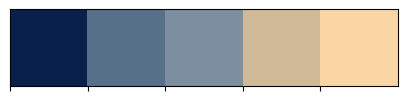

In [17]:
# задание палитры цветов
colors = ["#09214a", "#567189", "#7B8FA1", "#CFB997", "#FAD6A5"]
sns.palplot(sns.color_palette(colors))

In [18]:
# подсчет количества оценок
cl_count = sub["Complience Level"].value_counts()

In [19]:
# наименование классов
cl_count.index.to_list()

['LC', 'NC', 'NA', 'FC']

In [20]:
# упорядочивание классов по значимости
col_names = [col_name for col_name in ["FC", "LC", "PC", "NC", "NA"] if col_name in cl_count.index.to_list()]

In [21]:
# упорядочивание классов по значимости
cl_count = cl_count[col_names]
cl_count

Complience Level
FC    1
LC    6
NC    4
NA    1
Name: count, dtype: int64

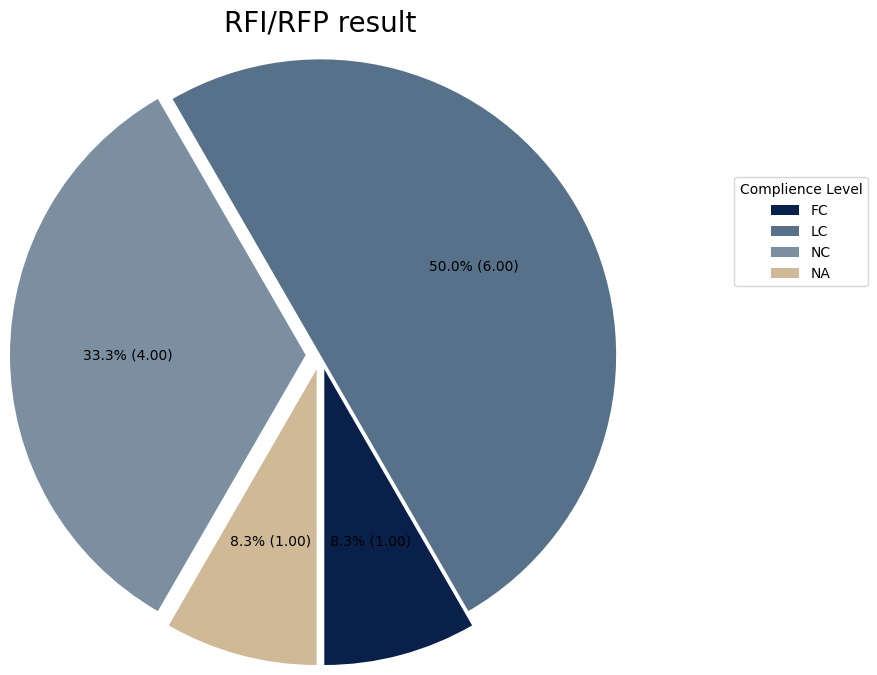

In [23]:
# визуализация соотношения оценок
def func(pct, allvals):
    absolute = float(pct/100.*np.sum(allvals))
    return "{:.1f}% ({:.2f})".format(pct, absolute)

plt.pie(cl_count , colors=colors[:len(col_names)], \
        autopct=lambda pct: func(pct, cl_count), radius=2, startangle = 270, explode = [0.1, 0, 0.1, 0.1, 0.05][:len(col_names)])
plt.title("RFI/RFP result", size = 20, pad=100)
plt.legend(labels=cl_count.index, title ="Complience Level", loc="upper right", bbox_to_anchor =(1.5, 0, 0.5, 1))
plt.show()